In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys
import glob
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../../sample_scripts/')
# from sample_scripts.sample_utils.inference_utils import to_tensor
# from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:0'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, size=3):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [2]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_cond_model.in_image = cfg.img_cond_model.in_image + ['faceseg_bg_noface&nohair'] + ['faceseg_eyes']
cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
img_ext = '.jpg'
cfg.dataset.training_data = 'ffhq_256_with_anno'
cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)


from importlib import reload
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() 
}        

sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')

from decalib import deca
from decalib.utils.config import cfg as deca_cfg
deca_cfg.model.use_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.extract_tex = True 
deca_obj = deca.DECA(config = deca_cfg, device=device, mode='', mask=mask)


[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead', 'faceseg_bg_noface&nohair', 'faceseg_eyes']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask


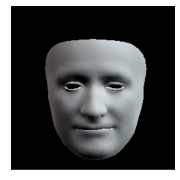

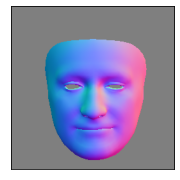

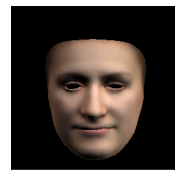

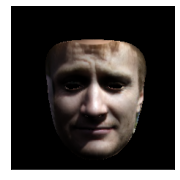

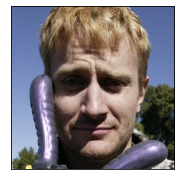

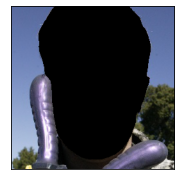

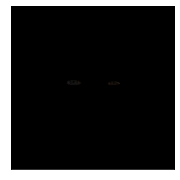

In [22]:

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60000.jpg', '60001.jpg', '60002.jpg', '60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1000,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, 
                                                        idx=0, n=1, 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False,
                                                        deca_obj=deca_obj)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(((orig_visdict['normal_images'] + 1) * 127.5).clamp_(0, 255).cpu())
show(grid/255)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images_uv_texture'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(model_kwargs['raw_image'].cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid((((model_kwargs['faceseg_bg_noface&nohair_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid((((model_kwargs['faceseg_eyes_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0)


In [40]:
print(orig_visdict.keys())
print(deca_obj.render.verts_tmp.shape)
# print(orig_visdict['trans_verts_orig'].shape)
# print(orig_visdict['verts'])
# print(orig_visdict['trans_verts'])
# print(orig_visdict['trans_verts_orig'])
# print(deca_obj.render.verts_tmp.cuda())
# print(th.allclose(orig_visdict['verts'], deca_obj.render.verts_tmp.cuda()))
# print(th.allclose(orig_visdict['trans_verts'], deca_obj.render.verts_tmp.cuda()))
# print(th.allclose(orig_visdict['trans_verts_orig'], deca_obj.render.verts_tmp.cuda()))

plot_verts = deca_obj.render.verts_tmp
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(x=plot_verts[0, :, 0], y=plot_verts[0, :, 1], z=plot_verts[0, :, 2],
                                   mode='markers', marker_size=0.7)])
fig.show()

mask={
    'v_mask':v_mask['left_eyeball'].tolist() + v_mask['right_eyeball'].tolist(),
    'f_mask':f_mask['left_eyeball'].tolist() + f_mask['right_eyeball'].tolist(),
}
print(v_mask.keys())

mid_righteye = th.mean(plot_verts[0, v_mask['right_eyeball'].tolist(), :], dim=0, keepdims=True).cpu().numpy()
mid_lefteye = th.mean(plot_verts[0, v_mask['left_eyeball'].tolist(), :], dim=0, keepdims=True).cpu().numpy()
print(mid_lefteye.shape)

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=plot_verts[0, mask['v_mask'], 0], y=plot_verts[0, mask['v_mask'], 1], z=plot_verts[0, mask['v_mask'], 2],
                                   mode='markers', marker_size=0.7))
fig.add_trace(go.Scatter3d(x=mid_lefteye[:, 0], y=mid_lefteye[:, 1], z=mid_lefteye[:, 2],
                                   mode='markers', marker_size=3,  marker_color='rgba(152, 0, 0, .8)'))
fig.add_trace(go.Scatter3d(x=mid_righteye[:, 0], y=mid_righteye[:, 1], z=mid_righteye[:, 2],
                                   mode='markers', marker_size=3,  marker_color='rgba(152, 0, 0, .8)'))
fig.show()

print("IPD : ", np.abs(mid_lefteye - mid_righteye))

# plot_verts = orig_visdict['verts'].cpu().numpy()
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Scatter3d(x=plot_verts[0, :, 0], y=plot_verts[0, :, 1], z=plot_verts[0, :, 2],
#                                    mode='markers', marker_size=0.7)])
# fig.show()

dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images', 'albedo_images', 'normal_images', 'rendered_images', 'rendered_images_pred_detail', 'rendered_images_uv_texture', 'verts', 'trans_verts', 'landmarks3d_world', 'trans_verts_orig', 'landmarks2d_orig', 'landmarks3d_orig', 'grid', 'alpha_images', 'albedo', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
torch.Size([1, 5023, 3])


dict_keys(['eye_region', 'neck', 'left_eyeball', 'right_eyeball', 'right_ear', 'right_eye_region', 'forehead', 'lips', 'nose', 'scalp', 'boundary', 'face', 'left_ear', 'left_eye_region'])
(1, 3)


IPD :  [[0.06290202 0.         0.        ]]


In [ ]:
from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = False
deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1000,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=20, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=None, repeat=False)
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=20, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=mask, repeat=False)
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

In [ ]:
from importlib import reload
reload(params_utils)
import tqdm

def gen_masked_face3d(batch_size, mask, set_, path):
    img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
    avail_img_name = [i.split('/')[-1] for i in img_path]
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=avail_img_name)
    dat = th.utils.data.Subset(dataset, indices=img_idx)
    subset_loader = th.utils.data.DataLoader(dat, batch_size=batch_size,
                                        shuffle=False, num_workers=24, drop_last=False)
    
    sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
    from decalib.deca import DECA
    from decalib.datasets import datasets 
    from decalib.utils import util
    from decalib.utils.config import cfg as deca_cfg
    deca_cfg.model.extract_tex = True
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.use_tex = False
    deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
    
    clip_path = f"{path}_wclip/{set_}"
    woclip_path = f"{path}_woclip/{set_}"
    os.makedirs(clip_path, exist_ok=True)
    os.makedirs(woclip_path, exist_ok=True)
    for batch_ndx, sample in tqdm.tqdm(enumerate(subset_loader)):
        dat, model_kwargs = sample
    
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=mask, repeat=False, deca_obj=deca)
        # grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
        # show(grid/255.0)
        
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            # np.save(file=f"{woclip_path}/{name}.npy", arr=rendered_image[i].cpu().numpy())
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}.png")
            
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=None, repeat=False, deca_obj=None)
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}_full.png")
        break
f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')

print(f_mask.keys())
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() + f_mask['boundary'].tolist() + f_mask['neck'].tolist() + f_mask['scalp'].tolist(),
    # 'f_mask':sum([f_mask[k].tolist() for k in f_mask.keys()], [])
}
gen_masked_face3d(1, mask, set_="valid", path="/data/mint/DPM_Dataset/ffhq_256_with_anno/rendered_images/deca_masked_face_images")

In [ ]:
from importlib import reload
reload(params_utils)
import tqdm

def gen_masked_face3d(batch_size, mask, set_, path):
    img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
    avail_img_name = [i.split('/')[-1] for i in img_path]
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=avail_img_name)
    dat = th.utils.data.Subset(dataset, indices=img_idx)
    subset_loader = th.utils.data.DataLoader(dat, batch_size=batch_size,
                                        shuffle=False, num_workers=24, drop_last=False)
    
    sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
    from decalib.deca import DECA
    from decalib.datasets import datasets 
    from decalib.utils import util
    from decalib.utils.config import cfg as deca_cfg
    deca_cfg.model.extract_tex = True
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.use_tex = False
    deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
    
    clip_path = f"{path}_wclip/{set_}"
    woclip_path = f"{path}_woclip/{set_}"
    os.makedirs(clip_path, exist_ok=True)
    os.makedirs(woclip_path, exist_ok=True)
    for batch_ndx, sample in tqdm.tqdm(enumerate(subset_loader)):
        dat, model_kwargs = sample
    
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=mask, repeat=False, deca_obj=deca)
        # grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
        # show(grid/255.0)
        
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            # np.save(file=f"{woclip_path}/{name}.npy", arr=rendered_image[i].cpu().numpy())
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}.png")
       
f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')

print(f_mask.keys())
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() + f_mask['boundary'].tolist() + f_mask['neck'].tolist() + f_mask['scalp'].tolist(),
    # 'f_mask':sum([f_mask[k].tolist() for k in f_mask.keys()], [])
}
gen_masked_face3d(1, mask, set_="valid", path="/data/mint/DPM_Dataset/ffhq_256_with_anno/rendered_images/deca_masked_face_images")

In [ ]:
print(model_kwargs.keys())
import cv2
edges = cv2.Canny(np.transpose(model_kwargs['raw_image'][0].cpu().numpy().astype(np.uint8), (1, 2, 0)), 190, 200)
plt.imshow(edges, cmap='gray')
plt.show()

# Create the masking faces indices 

In [ ]:
assert False    # Remove this line
from model_3d.FLAME.config import cfg as flame_cfg
import model_3d.FLAME.FLAME as FLAME
import model_3d.FLAME.utils.renderer as renderer_lib
import model_3d.FLAME.utils.util as util
from importlib import reload
import numpy as np
reload(renderer_lib)
reload(FLAME)

flame = FLAME.FLAME(flame_cfg.model).cuda()
renderer = renderer_lib.SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()
print(renderer.faces.shape)
print(renderer.face_colors.shape)


def index_masking_faces(mask, faces):
    print("[#] Create indexing masked of faces...")
    import tqdm, pickle
    rm_faces = {}
    for k in mask.keys():
        rm_faces[k] = []
        print("Processing : ", k)
        for m in tqdm.tqdm(mask[k].tolist()):
            for i, f in enumerate(faces[0]):
                if m in f:
                    rm_faces[k].append(i)
        rm_faces[k] = np.array(rm_faces[k])
    
    with open('FLAME_masks_face-id.pkl', 'wb') as output:
        pickle.dump(rm_faces, output)

mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
count = 0
mask_list = []
for k, v in mask.items():
    count += len(v)
    print(f"{k} - {v.shape}")
    mask_list.append(v)
mask_list = np.concatenate(mask_list, -1)

print(renderer.faces.shape)
print(type(mask['face'][0]))
print("#"*50)
index_masking_faces(mask, renderer.faces)